Best Hyperparameters: {'max_depth': None, 'n_estimators': 100}

Prediction for 2025-03-24:
Base (Last Training) Close: 117.70
Predicted Close: 118.45
Predicted Return: 0.63%
Recommended Action: Buy
Investment Fraction: 400000%
Investment Amount: $4,000.00


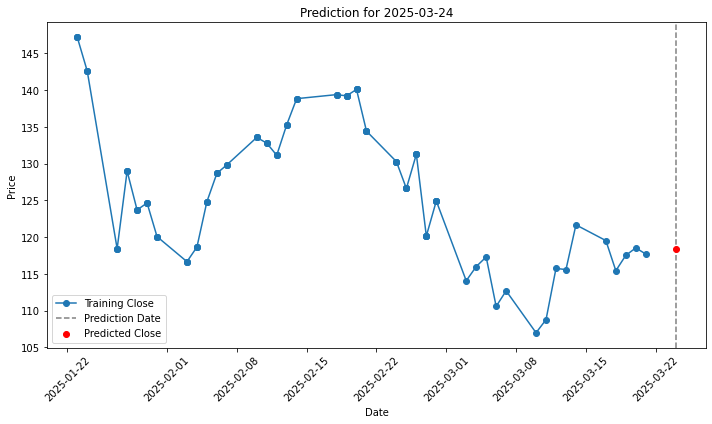

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

#Loadings our data here
df = pd.read_csv('Stock_Data.csv')
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

#Clean the data for whitespaces, commas, make sure they are the correct data type
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in columns:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=columns, inplace=True)

#Adds dummy row for a future date if missing in order to predict without errors
fake_date = pd.Timestamp('2025-03-22')
if fake_date not in df['date'].values:
    final_row = df.iloc[-1].copy()
    final_row['date'] = fake_date
    final_close = final_row['Close']
    final_row['Open'] = final_close
    final_row['High'] = final_close
    final_row['Low']  = final_close
    final_row['Close'] = final_close
    final_row['Volume'] = 0
    df = df.append(final_row, ignore_index=True)
    df = df.sort_values('date').reset_index(drop=True)


#Selection of advanced features here as well as calcualtion of relative strength index
df['movingavg'] = df['Close'].rolling(window=5).mean()
df['Return'] = df['Close'].pct_change()

def CalcRSI(series, window=7):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(window=window).mean()
    roll_down = down.rolling(window=window).mean()
    rs = roll_up / roll_down
    rsi = 100 - (100 / (1 + rs))
    return rsi



df['RSI'] = CalcRSI(df['Close'], window=7)
df['Volatilty'] = df['Return'].rolling(window=3).std()

df['FirstLagC'] = df['Close'].shift(1)
df['SecLagC'] = df['Close'].shift(2)
df['FirstLagR'] = df['Return'].shift(1)
df['SecLagR'] = df['Return'].shift(2)

#Create our target here
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)


# Select which day we want to simulate for
simulatedate = pd.Timestamp('2025-03-24')

#Creating a rolling window for training data (set to 60 days due to volatile market changes in the last 2 months)
marketdays = 60
start_date = simulatedate - pd.Timedelta(days=marketdays)
train_subset = df[(df['date'] >= start_date) & (df['date'] < simulatedate)].copy()
if train_subset.empty:
    raise ValueError("Not enough training data available before the simulation date.")

#Define our features completely
features = ['Close', 'movingavg', 'movingavg', 'Volume', 'Return', 'RSI', 'Volatilty',
            'FirstLagC', 'SecLagC', 'FirstLagR', 'SecLagR']

# Model is trained here
X_train = train_subset[features]
y_train = train_subset['Target']

#We use hyperparameter tuning along with timeseries split to tune our random forest model
tscv = TimeSeriesSplit(n_splits=3)
#Can adjust the parameters more but gotta watch out for overfitting
parametergrid = {'n_estimators': [100, 200], 'max_depth': [None, 5, 10]}
RF = RandomForestRegressor(random_state=42)
gridsearch = GridSearchCV(RF, parametergrid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
gridsearch.fit(X_train, y_train)
HP = gridsearch.best_params_
print("Best Hyperparameters:", HP)

model = RandomForestRegressor(**HP, random_state=42)
model.fit(X_train, y_train)

#Make our prediction here mainly what will be the close price and possible return
final_row = train_subset.iloc[-1]
testfeatures = final_row[features].values.reshape(1, -1)
predicted_closeP = model.predict(testfeatures)[0]

base_closeP = final_row['Close']
predicted_returnR = (predicted_closeP - base_closeP) / base_closeP

#Define the threshold-based decision to decide if we want to sell buy or hold
if predicted_returnR > 0.0015:
    decision = "Buy"
elif predicted_returnR < -0.001:
    decision = "Sell"
else:
    decision = "Hold"

decisionratios= {
    "Buy": 0.40,
    "Hold": 0.10,
    "Sell": 0.00
}

startingfund = 10000
investmentamount = decisionratios[decision]
investmentamount = startingfund * investmentamount

#Results are outputted here
print(f"\nPrediction for {simulatedate.date()}:")
print(f"Base (Last Training) Close: {base_closeP:.2f}")
print(f"Predicted Close: {predicted_closeP:.2f}")
print(f"Predicted Return: {predicted_returnR*100:.2f}%")
print(f"Recommended Action: {decision}")
print(f"Investment Percentage: {investmentamount*100:.0f}%")
print(f"Investment Amount: ${investmentamount:,.2f}")

#We plot the results here for better visualization
plt.figure(figsize=(10,6))
plt.plot(train_subset['date'], train_subset['Close'], label='Training Close', marker='o', linestyle='-')
plt.axvline(simulatedate, color='gray', linestyle='--', label='Prediction Date')
plt.scatter(simulatedate, predicted_closeP, color='red', label='Predicted Close', zorder=5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Prediction for {simulatedate.date()}')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
